In [ ]:
%matplotlib inline


In [ ]:
# !pip install dgl
!pip install dgl==1.0.1
!pip install torch==2.0.0
!pip install node2vec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import dgl
import dgl.data
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import SAGEConv
import dgl.function as fn
import itertools
import numpy as np
import scipy.sparse as sp
import sklearn.metrics
from node2vec import Node2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score,roc_curve

In [ ]:
dataset = dgl.data.CoraGraphDataset()
g = dataset[0]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [ ]:
u, v = g.edges()

In [ ]:
edge_ids = np.arange(g.number_of_edges())
edge_ids = np.random.permutation(edge_ids)
test_size = int(len(edge_ids) * 0.1)
train_size = g.number_of_edges() - test_size
test_pos_u, test_pos_v = u[edge_ids[:test_size]], v[edge_ids[:test_size]]
train_pos_u, train_pos_v = u[edge_ids[test_size:]], v[edge_ids[test_size:]]

In [ ]:
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

neg_edge_ids = np.random.choice(len(neg_u), g.number_of_edges() // 2)
test_neg_u, test_neg_v = neg_u[neg_edge_ids[:test_size]], neg_v[neg_edge_ids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_edge_ids[test_size:]], neg_v[neg_edge_ids[test_size:]]

In [ ]:
train_g = dgl.remove_edges(g, edge_ids[:test_size])

In [ ]:
def get_optimal_threshold(tpr, fpr, thresholds):
  g_means = tpr*(1-fpr)
  max_index = np.argmax(g_means)
  return thresholds[max_index]

In [ ]:
def binarize_scores(scores, labels, optimal_threshold):
  final_preds = []
  for i in range(len(scores)):
    if(scores[i]<=optimal_threshold):
      final_preds.append(0)
    else:
      final_preds.append(1)
  return np.asarray(final_preds)

# Logistic Regression

In [ ]:
train_u,train_v = train_g.edges()

In [ ]:
nx_g = dgl.to_networkx(train_g)
node2vec = Node2Vec(nx_g, dimensions=100, walk_length=20,num_walks=20)

Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 20/20 [00:07<00:00,  2.57it/s]


In [ ]:
# train node2vec model
n2w_model = node2vec.fit(window=7, min_count=1)

In [ ]:
x = [(n2w_model.wv[str(i)]+n2w_model.wv[str(j)]) for i,j in zip(train_pos_u.tolist()+train_neg_u.tolist(),train_pos_v.tolist()+train_neg_v.tolist())]

In [ ]:
link_data = [1]*len(train_pos_u.tolist())+[0]*len(train_neg_u.tolist())

In [ ]:
xtrain, xtest, ytrain, ytest = sklearn.model_selection.train_test_split(np.array(x), link_data, test_size = 0.3, random_state = 35)

In [ ]:
lr = LogisticRegression(class_weight="balanced")
lr.fit(xtrain, ytrain)

LogisticRegression(class_weight='balanced')

In [ ]:
predictions_node2vec = lr.predict_proba(xtest)

In [ ]:
auc_score = roc_auc_score(ytest, predictions_node2vec[:,1])
tpr, fpr, thresholds = roc_curve(ytest, predictions_node2vec[:,1])

In [ ]:
optimal_threshold = get_optimal_threshold(tpr, fpr, thresholds)
binarized_preds = binarize_scores(predictions_node2vec[:,1], ytest, optimal_threshold)

In [ ]:
print('AUC', auc_score)
print("accuracy: ",sklearn.metrics.accuracy_score(ytest,binarized_preds))
print("F-measure: ",sklearn.metrics.f1_score(ytest,binarized_preds))
print("Precision: ",sklearn.metrics.precision_score(ytest,binarized_preds) )
print("Recall: ",sklearn.metrics.recall_score(ytest,binarized_preds))

AUC 0.595001892501439
accuracy:  0.5706653715395823
F-measure:  0.6609129267357116
Precision:  0.7369546621043627
Recall:  0.599095966620306


# GCN





In [ ]:
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, h_feats)
    
    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [ ]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

In [ ]:
class SumPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # computing score
            g.apply_edges(lambda edges: {'score': torch.sum(edges.src['h'] + edges.dst['h'], dim=-1)})
            return g.edata['score']


In [ ]:
from dgl.nn import GraphConv
model = GCN(train_g.ndata['feat'].shape[1], 16)
pred = SumPredictor()

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores),scores,labels, roc_curve(labels, scores)

In [ ]:
import dgl

# add self-loops to the graph
train_g = dgl.add_self_loop(train_g)

# define optimizer
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# train the model
all_logits = []
for e in range(100):
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if e % 5 == 0:
        print('In epoch ',e,' loss: ', loss)


In epoch  0  loss:  tensor(0.6917, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


/usr/local/lib/python3.10/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch  5  loss:  tensor(0.5894, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
In epoch  10  loss:  tensor(0.5819, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
In epoch  15  loss:  tensor(0.5711, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
In epoch  20  loss:  tensor(0.5562, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
In epoch  25  loss:  tensor(0.5417, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
In epoch  30  loss:  tensor(0.5286, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
In epoch  35  loss:  tensor(0.5186, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
In epoch  40  loss:  tensor(0.5121, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
In epoch  45  loss:  tensor(0.5058, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
In epoch  50  loss:  tensor(0.5013, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
In epoch  55  loss:  tensor(0.4974, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
In epoch  60  loss:  tensor(0.4946, grad_fn=<BinaryCrossEntropyWit

In [ ]:
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    auc_score, scores, labels, (tpr, fpr, thresholds) = compute_auc(pos_score, neg_score)
    opt_threshold = get_optimal_threshold(tpr, fpr, thresholds)
    binarized_preds = binarize_scores(scores,labels, opt_threshold)
    print('AUC', auc_score)
    print("accuracy: ",sklearn.metrics.accuracy_score(labels,binarized_preds))
    print("F-measure: ",sklearn.metrics.f1_score(labels,binarized_preds))
    print("Precision: ",sklearn.metrics.precision_score(labels,binarized_preds) )
    print("Recall: ",sklearn.metrics.recall_score(labels,binarized_preds))

AUC 0.724758203993621
accuracy:  0.6440758293838863
F-measure:  0.6727668845315904
Precision:  0.6225806451612903
Recall:  0.7317535545023697


# GraphSAGE

In [ ]:
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')
    
    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [ ]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

In [ ]:
class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            #computing score
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return g.edata['score'][:, 0]

In [ ]:
model = GraphSAGE(train_g.ndata['feat'].shape[1], 16)
pred = DotPredictor()

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores),scores,labels, roc_curve(labels, scores)

In [ ]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

all_logits = []
for e in range(100):
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if e % 5 == 0:
        print('In epoch ',e,' loss: ', loss)

In epoch  0  loss:  tensor(0.6593, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


/usr/local/lib/python3.10/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch  5  loss:  tensor(0.6163, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
In epoch  10  loss:  tensor(0.6056, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
In epoch  15  loss:  tensor(0.5887, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
In epoch  20  loss:  tensor(0.5671, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
In epoch  25  loss:  tensor(0.5369, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
In epoch  30  loss:  tensor(0.4941, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
In epoch  35  loss:  tensor(0.4536, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
In epoch  40  loss:  tensor(0.4143, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
In epoch  45  loss:  tensor(0.3783, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
In epoch  50  loss:  tensor(0.3489, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
In epoch  55  loss:  tensor(0.3264, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
In epoch  60  loss:  tensor(0.3067, grad_fn=<BinaryCrossEntropyWit

In [ ]:
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    auc_score, scores, labels, (tpr, fpr, thresholds) = compute_auc(pos_score, neg_score)
    opt_threshold = get_optimal_threshold(tpr, fpr, thresholds)
    binarized_preds = binarize_scores(scores,labels, opt_threshold)
    print('AUC', auc_score)
    print("accuracy: ",sklearn.metrics.accuracy_score(labels,binarized_preds))
    print("F-measure: ",sklearn.metrics.f1_score(labels,binarized_preds))
    print("Precision: ",sklearn.metrics.precision_score(labels,binarized_preds) )
    print("Recall: ",sklearn.metrics.recall_score(labels,binarized_preds))

AUC 0.8357314525729431
accuracy:  0.7213270142180095
F-measure:  0.6872340425531915
Precision:  0.7830303030303031
Recall:  0.6123222748815166


# EDA

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
G = nx.Graph()

In [ ]:
# read data
df = pd.read_csv("cites.csv")
df_paper = pd.read_csv("paper.csv")

In [ ]:
color_dict = {'Genetic_Algorithms':'green','Reinforcement_Learning':'red','Theory':'teal','Rule_Learning':'blue','Case_Based':'yellow','Probabilistic_Methods':'pink','Neural_Networks':'orange'}
nodes_dict = {}

nodes_list = df_paper.apply(lambda x: [x[0],x[1]],axis=1)
for item in nodes_list:
  nodes_dict[item[0]] = item[1]

In [ ]:
color_map=[]

for node in G:
  color_map.append(color_dict[nodes_dict[node]])

In [ ]:
edges = list(df.apply(lambda x: (x[0],x[1]),axis=1))

In [ ]:
G.add_edges_from(edges)

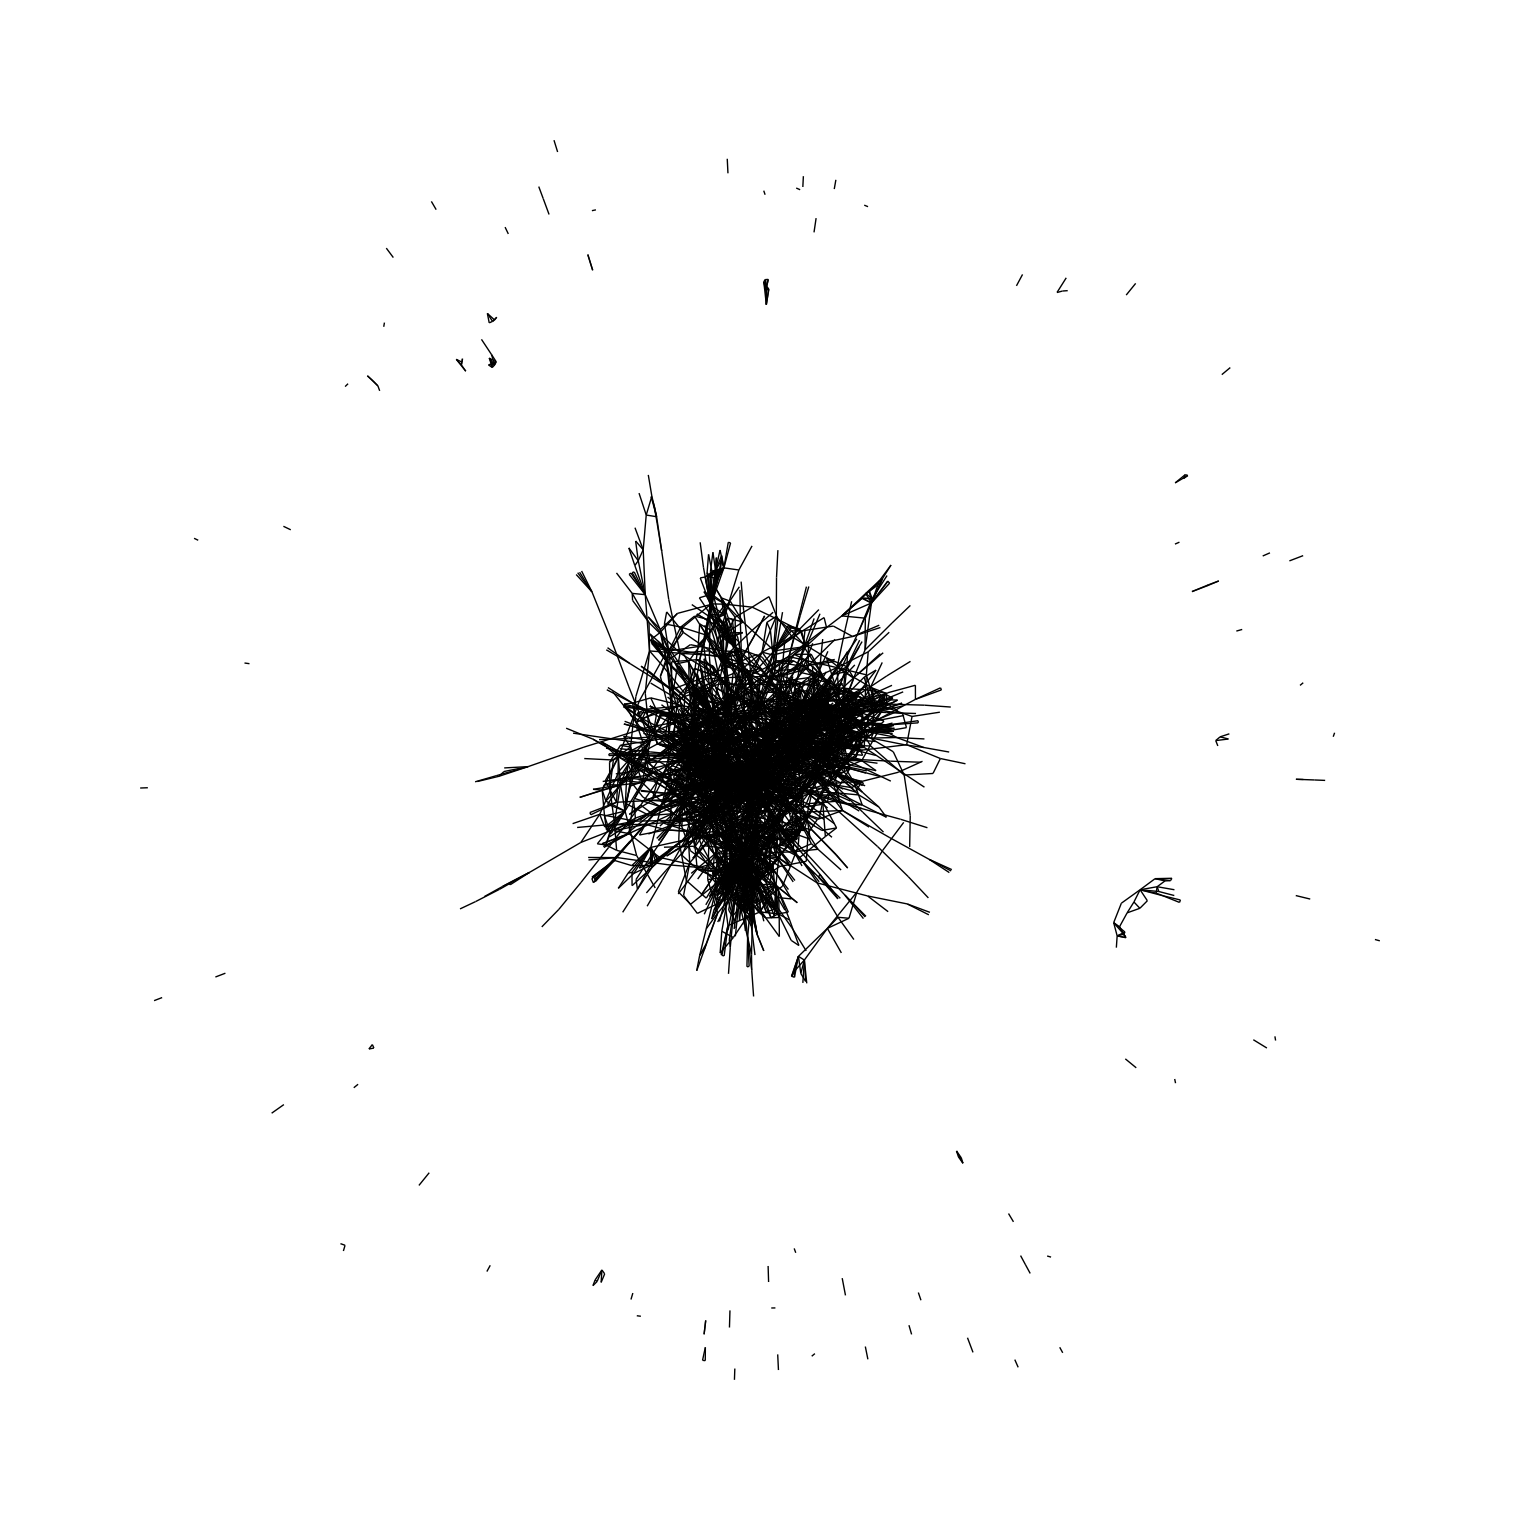

In [ ]:
plt.figure(3,figsize=(15,15))
nx.draw(G, node_color=color_map)
plt.show()

In [ ]:
G.number_of_nodes()

2708

In [ ]:
depths_graph = nx.shortest_path_length(G)
max_clique_size = nx.algorithms.clique.graph_clique_number(G)
max_clique_size

5

In [ ]:
import plotly.express as px

In [ ]:
counts_df = df_paper.groupby('class_label').size().to_frame('count')

In [ ]:
counts_df = counts_df.reset_index()

In [ ]:
fig = px.bar(counts_df, x='class_label', y='count',text_auto='.2s',title="Counts of papers in each class")
fig.show()

In [ ]:
sorted_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:5]

In [ ]:
for node in sorted_nodes:
  print(node,nodes_dict[node[0]])

(35, 168) Genetic_Algorithms
(6213, 78) Reinforcement_Learning
(1365, 74) Neural_Networks
(3229, 65) Neural_Networks
(910, 44) Neural_Networks


In [ ]:
nx.algorithms.clique.graph_number_of_cliques(G)

3563

In [ ]:
max_cliques = []
for clique in nx.find_cliques(G):
  if len(clique)==5:
     max_cliques.append(clique)

In [ ]:
for max_clique in max_cliques:
  print("clique: ",max_clique)
  for node in max_clique:
    print(node,nodes_dict[node])

clique:  [8224, 22431, 49843, 49844, 49847]
8224 Theory
22431 Rule_Learning
49843 Rule_Learning
49844 Rule_Learning
49847 Rule_Learning
clique:  [1122642, 34257, 34266, 34263, 90655]
1122642 Neural_Networks
34257 Neural_Networks
34266 Neural_Networks
34263 Neural_Networks
90655 Neural_Networks
clique:  [1123188, 6910, 12638, 12631, 662416]
1123188 Neural_Networks
6910 Neural_Networks
12638 Neural_Networks
12631 Neural_Networks
662416 Probabilistic_Methods
clique:  [1123188, 6910, 12638, 12631, 6898]
1123188 Neural_Networks
6910 Neural_Networks
12638 Neural_Networks
12631 Neural_Networks
6898 Neural_Networks
clique:  [124064, 6213, 6224, 6163, 6220]
124064 Reinforcement_Learning
6213 Reinforcement_Learning
6224 Reinforcement_Learning
6163 Reinforcement_Learning
6220 Reinforcement_Learning
clique:  [10435, 1103394, 22563, 22564, 22566]
10435 Case_Based
1103394 Case_Based
22563 Neural_Networks
22564 Case_Based
22566 Case_Based
clique:  [10531, 31353, 686532, 31349, 31336]
10531 Neural_Net

In [ ]:
len(max_cliques)

9

In [ ]:
paper_cites_counts = df.groupby('cited_paper_id').size().to_frame('degree').reset_index()

In [ ]:
def add_degree(row):
  global paper_cites_counts
  # print(row['paper_id'])
  degree_list = paper_cites_counts.loc[paper_cites_counts['cited_paper_id']==row['paper_id'],'degree'].tolist()
  if len(degree_list) != 1:
    return 0
  return degree_list[0]

In [ ]:
df_paper['degree'] = 0

In [ ]:
df_paper['degree'] = df_paper.apply(add_degree, axis=1)

In [ ]:
df_paper.to_csv("paper_with_degree.csv",index=False)

In [ ]:
len(paper_cites_counts['cited_paper_id'].unique())

1565

In [ ]:
len(df['citing_paper_id'].unique())

2222